In [ ]:
#The code should be run in a linear manner

In [1]:
import numpy as np
import torch
import torchtext
from torchtext import data
import torch.optim as optim
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# TextDataset is Described in Section 3.3 of Assignment 2
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "data"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V - 1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X
        self.Y = torch.tensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    # my_collate_function prepares batches

# it also pads each batch with zeroes.

def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function 
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device), 
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x, y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x, y in batch:
        #x padded
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

In [42]:
class MLPClassifier(torch.nn.Module):
    def __init__(self, word_vec, embedding_size):
        super().__init__()
        self.embed=torch.nn.Embedding.from_pretrained(word_vec)
        self.fc1 = torch.nn.Linear(embedding_size, 1)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        torch.manual_seed(26)
        if isinstance(module, torch.nn.Linear):
            module.weight.data.normal_(0, 0.3)
            #print(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, input):
        squash=torch.nn.Sigmoid()
        pred= self.embed(input)
        pred= torch.mean(pred, dim=0)
        pred= squash(self.fc1(pred))
        return pred

Using device: cuda
Memory allocated by device: 660126208
Avg test loss= tensor(0.5562, device='cuda:0', grad_fn=<DivBackward0>) Test accu= tensor(0.8915, device='cuda:0')


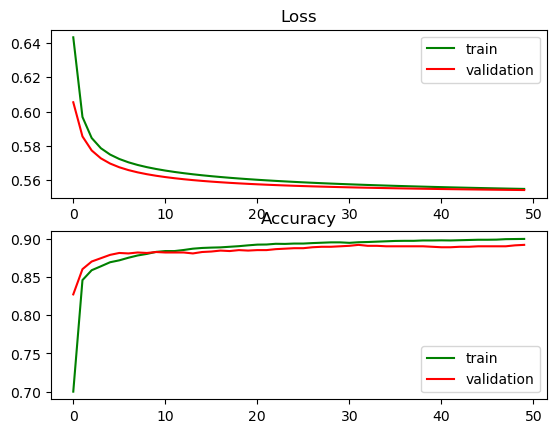

In [68]:
def decision(input,labels):
    return torch.sum((input>0.5)==labels)
def main(args):
    #   fix seed
    torch.manual_seed(2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Using device:", device)

    ### 3.3 Processing of the data ###
    # 3.3.1
    glove = torchtext.vocab.GloVe(name="6B", dim=100)  # embedding size = 100

    # 3.3.2
    train_dataset = TextDataset(glove, "train")
    val_dataset = TextDataset(glove, "validation")
    test_dataset = TextDataset(glove, "test")

    # 3.3.3
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))


    net=MLPClassifier(glove.vectors.cuda(),100).cuda()
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    num_epochs=50

    loss_train=np.zeros(num_epochs)
    loss_val=np.zeros(num_epochs)
    accu_train=np.zeros(num_epochs)
    accu_val=np.zeros(num_epochs)
    print('Memory allocated by device:', torch.cuda.memory_allocated(device))
    for i in range(int(num_epochs)):
        train_iter=iter(train_dataloader) 
        val_iter=iter(validation_dataloader)
        while True:
            try:    
                input, labels = next(train_iter)
                output = net(input.cuda())
                optimizer.zero_grad()  # zero the gradient buffers
                loss = criterion(output[:,0], labels.float())
                loss.backward()
                optimizer.step()
                loss_train[i]+=loss
                accu_train[i]+=decision(output[:,0],labels)
            except StopIteration:
                break
        while True:
            try:
                input, labels = next(val_iter)
                output = net(input.cuda())
                loss = criterion(output[:,0], labels.float())
                loss_val[i]+=loss
                accu_val[i]+=decision(output[:,0],labels)
            except StopIteration:
                break

    loss_train/=6400/args.batch_size #avg loss per sample
    loss_val/=1600/args.batch_size #avg loss per sample
    accu_train/=6400
    accu_val/=1600
    
    #plotting section
    fig, splot = plt.subplots(2)
    domain = np.arange(num_epochs)
    splot[0].plot(domain, loss_train, 'g',label="train")
    splot[0].plot(domain, loss_val, 'r',label="validation")
    splot[0].legend()
    splot[0].title.set_text("Loss")
    splot[1].plot(domain, accu_train, 'g',label="train")
    splot[1].plot(domain, accu_val, 'r',label="validation")
    splot[1].legend()
    splot[1].title.set_text("Accuracy")

    #print final test loss and accuracy
    test_iter=iter(test_dataloader)
    loss=0
    accu=0
    while True:
        try:
            input, labels = next(test_iter)
            output = net(input.cuda())
            loss += criterion(output[:,0], labels.float())
            accu+=decision(output[:,0],labels)
        except StopIteration:
            break
    loss/=2000
    accu=accu/torch.tensor(2000)
    print("Avg test loss=",loss,"Test accu=",accu)

    return net
    
class Args:
    def __init__(self, bs):
        self.batch_size = bs
        
net=main(Args(1))

In [69]:
state_dict = net.state_dict()
print(state_dict['embed.weight'].size())
subject=state_dict['fc1.weight'].cpu()
print(subject)

glove = torchtext.vocab.GloVe(name="6B", dim=100)  # embedding size = 100
def print_closest_cosine_words(vec, n=20):
    dists = torch.cosine_similarity(glove.vectors, vec, dim=1)
    lst = sorted(enumerate(dists.numpy()), key=lambda x: x[1],reverse=True) # sort by distance
    for idx, difference in lst[0:n]:                         # take the top n
        print(glove.itos[idx], "\t%5.3f" % difference)
    print("\n")

print_closest_cosine_words(subject)

torch.Size([400000, 100])
tensor([[-4.2033e+00,  2.4929e+00,  1.4166e+00,  5.6710e-02, -2.2345e+00,
          3.0203e-01, -8.5676e-01, -5.5575e-01, -1.6426e+00,  7.3289e-01,
         -9.7128e-01, -1.1084e+00, -4.9023e+00, -9.3762e+00,  4.4847e+00,
          3.3624e+00, -5.6282e+00,  1.6767e+00,  7.0774e+00,  2.3600e+00,
          1.3431e+00,  2.9515e+00, -1.7907e+00, -4.0708e+00,  3.2045e+00,
         -1.6198e+00, -2.2213e+00,  4.3507e+00, -1.8037e+00, -9.9056e+00,
          5.9849e+00, -1.4779e+00, -1.5438e+00, -4.4969e-01, -3.4094e-01,
          4.4938e+00,  3.9289e+00,  3.8187e+00, -2.2222e+00,  1.5691e+00,
          6.0224e+00,  9.0672e-01, -5.4429e+00,  3.2659e+00, -1.4367e+00,
          1.1557e+00,  3.9612e+00, -3.7335e+00, -6.2612e+00, -3.3578e+00,
          1.9259e+00, -3.2021e+00,  7.1963e-01, -9.8105e-01, -2.1040e+00,
         -2.8538e-01,  1.1556e+00, -8.0686e-03,  6.8258e-01, -4.7271e+00,
         -2.3309e-01,  1.5387e+00, -1.0132e+00,  3.6027e+00, -6.2327e-01,
         -5.

In [70]:
torch.save(net.state_dict(), 'baseline.pt')